# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Introdução

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado**.


## Sobre os dados


Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). Todos os dados são de pacientes mulheres de pelo menos 21 anos de idade. As *features* são:

* Pregnancies: Número de eventos de gravidez; 
* Glucose: Concentração de glicose plasmática;
* BloodPressure: Pressão sanguínea diastólica ($mmHg$);
* SkinThickness: Grossura da dobra da pele do tríceps ($mm$);
* Insulin: Insulina sérica ($\mu U/mL$);
* BMI: *Body mass index*, Peso em $kg$ / (altura em $m$)$^2$;
* DiabetesPedigreeFunction: mede a possibilidade de diabetes dado o histórico familiar;
* Age: Idade (anos);
* Outcome: Target, 0 para não-diabético, 1 para diabético.



## Problema de negócio e avaliação do modelo

O custo de exame e de prevenção são significativamente menores que os custos de tratamento da diabetes. Além disso, a detecção precoce facilita o tratamento (https://www.previva.com.br/reduzir-custo-do-diabetes/).

Considerando essas informações, a métrica que utilizaremos para avaliar o modelo será o **recall**, uma vez que queremos diagnosticar o máximo de pacientes, ainda que perdendo precisão. Compararemos nossos resultados com um modelo empírico baseado na concentração de glicose. 

Utilizaremos os seguintes dados fictícios para simular o gasto público: o custo de tratamento é de $R\$$ 200/paciente x mês, enquanto o custo de exame/prevenção é de $R\$$ 50,00 / paciente x mês.

## Importando e explorando os dados

In [1]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [2]:
data = pd.read_csv("data/diabetes.csv")

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Não que seja necessário nesse caso, mas podemos reduzir o uso de memória alterando os dtypes.

In [6]:
int_cols = list(data.select_dtypes('int64').columns) 
float_cols = list(data.select_dtypes('float64').columns)

for col in int_cols:
    data[col] = data[col].astype('int16')   # Não temos valores fora de [-32767, +32767]
    
for col in float_cols:
    data[col] = data[col].astype('float32') # 32bits é suficiente para precisão que temos

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   768 non-null    int16  
 2   BloodPressure             768 non-null    int16  
 3   SkinThickness             768 non-null    int16  
 4   Insulin                   768 non-null    int16  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 16.6 KB


Tivemos uma redução significativa de uso de memória.

In [9]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos ({100*data[col].eq(0).sum()/data.shape[0]:.1f} %) em {col}.")

111 valores nulos (14.5 %) em Pregnancies.
5 valores nulos (0.7 %) em Glucose.
35 valores nulos (4.6 %) em BloodPressure.
227 valores nulos (29.6 %) em SkinThickness.
374 valores nulos (48.7 %) em Insulin.
11 valores nulos (1.4 %) em BMI.
0 valores nulos (0.0 %) em DiabetesPedigreeFunction.
0 valores nulos (0.0 %) em Age.
500 valores nulos (65.1 %) em Outcome.


Valores nulos de `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` são na verdade dados faltantes (NaN). A coluna `Insulin` possui uma quantidade significativa de NaN.

Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [10]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.700001,0.140,22,0
182,1,0,74,20,23,27.700001,0.299,21,0
342,1,0,68,35,0,32.000000,0.389,22,0
349,5,0,80,32,0,41.000000,0.346,37,1
502,6,0,68,41,0,39.000000,0.727,41,1


In [11]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias nulas em `Glucose` e são relativamente homogêneas.

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

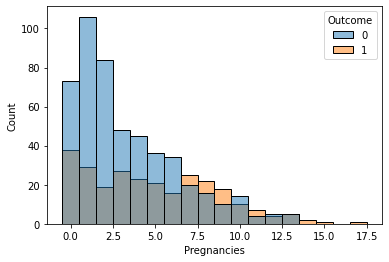

In [12]:
_ = sns.histplot(data, x="Pregnancies", hue="Outcome", discrete=True)

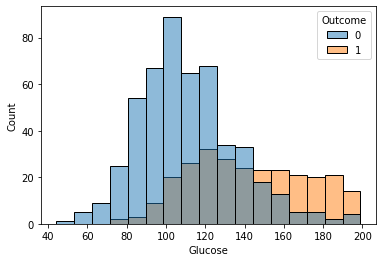

In [13]:
_ = sns.histplot(data[data["Glucose"] != 0], x="Glucose", hue="Outcome")

In [14]:
# Algumas métricas separadas para outcomes

data.loc[data['Glucose'] > 0,['Outcome', 'Glucose']].groupby('Outcome').describe()

Glucose                                                         
          count        mean        std   min    25%    50%    75%    max
Outcome                                                                 
0         497.0  110.643863  24.776906  44.0   93.0  107.0  125.0  197.0
1         266.0  142.319549  29.599199  78.0  119.0  140.0  167.0  199.0

As médias são razoavelmente diferentes, mas os desvios são relativamentos próximos.

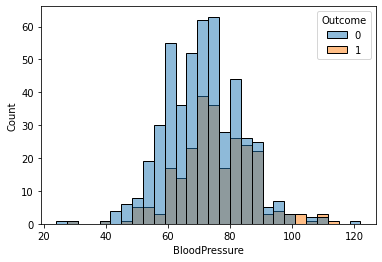

In [15]:
_ = sns.histplot(data[data["BloodPressure"] != 0], x="BloodPressure", hue="Outcome")

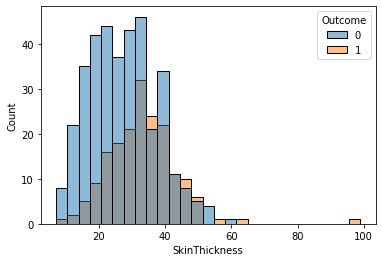

In [16]:
_ = sns.histplot(data[data["SkinThickness"] != 0], x="SkinThickness", hue="Outcome")

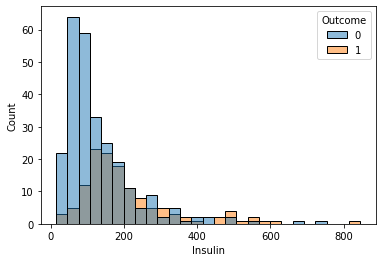

In [17]:
_ = sns.histplot(data[data["Insulin"] != 0], x="Insulin", hue="Outcome")

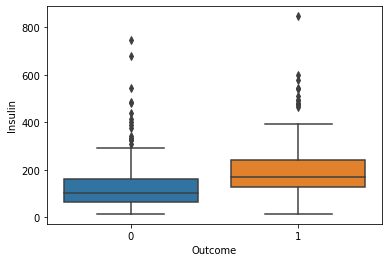

In [18]:
_ = sns.boxplot(data=data[data["Insulin"] != 0], x="Outcome", y="Insulin")

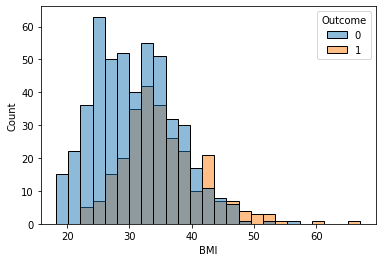

In [19]:
_ = sns.histplot(data[data["BMI"] != 0], x="BMI", hue="Outcome")

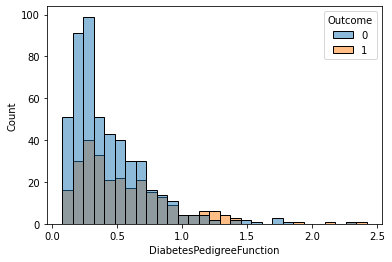

In [20]:
_ = sns.histplot(data, x="DiabetesPedigreeFunction", hue="Outcome")

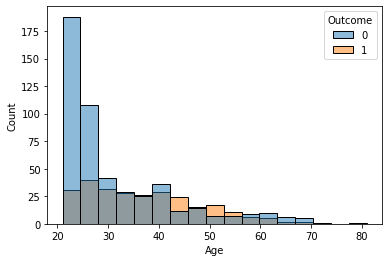

In [21]:
_ = sns.histplot(data, x="Age", hue="Outcome")

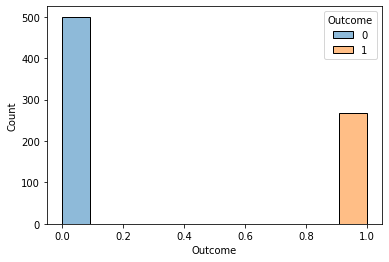

In [22]:
_ = sns.histplot(data, x="Outcome", hue="Outcome")

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


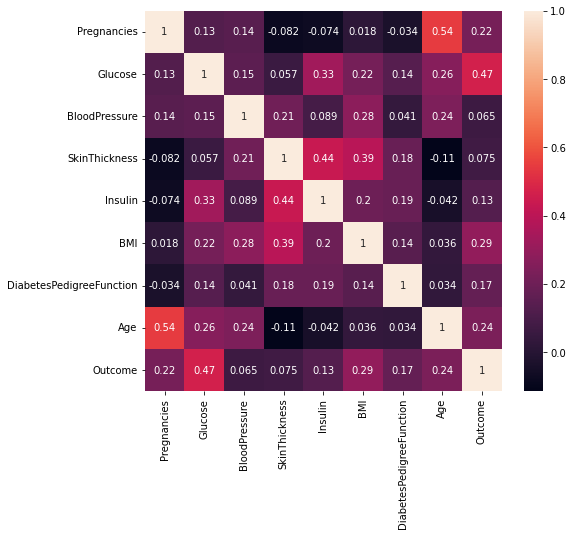

In [23]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))   

correlacao(data)

plt.figure(figsize=(8,7))
_ = sns.heatmap(data=data.corr(), annot=True)

A partir da EDA podemos concluir que nossa *target* `Outcome` é suficientemente balanceada e é bem correlacionada com `Glucose`, `BMI`, `Age` e `Preganancies`. Entretanto, parece já existir uma dependência entre `Age` e `Preganancies`. Também parece haver algum grau de codepêndencia entre `SkinThickness`, `BMI` e `Insulin`.

## Redifinindo dados faltantes e separação treino/teste

A partir de agora corrigiremos os valores nulos por NaN e reservaremos nosso dataset de teste para o final.

In [24]:
# Vamos substituir 0 por NaN e salvar um novo csv

data_tr = data.copy()

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_tr[col] = data_tr[col].replace(0, np.nan)

data_tr.to_csv('data/data_tr.csv', index=False)

data_tr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.599998,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.299999,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.099998,2.288,33,1


In [25]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), float64(4), int16(3)
memory usage: 34.6 KB


As colunas que tinham NaN viram floats uma vez que esse tipo de dado não é suportado por integers.

In [26]:
# Separação de features e targets
X = data_tr.drop('Outcome', axis=1)
y = data_tr['Outcome']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

## Modelo de referência

Nosso modelo heurístico é baseado no fato que a taxa de glicose deve ser o parâmetro mais importante para determinar se um paciente é diabético. Dito isto, vamos tentar achar um valor ideal de `Glucose` que nos dê o melhor resultado.

In [27]:
# Criar um X,y para modelo de referência, dropando os NaNs

filtro_nan = X_train['Glucose'].isna()
index_nan = X_train[filtro_nan].index.tolist()

X_train_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_train_heuristic = y_train.drop(index=index_nan)

In [28]:
# Treinando o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []
recall_list = []
precision_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0
    
for thr in glucose_thr:
    outcome_predict = X_train_heuristic["Glucose"].apply(test_glucose, thr=thr)
    
    accuracy = np.round(accuracy_score(y_train_heuristic, outcome_predict), 4)
    precision = np.round(precision_score(y_train_heuristic, outcome_predict), 4)
    recall = np.round(recall_score(y_train_heuristic, outcome_predict), 4)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

Utilizaremos o cruzamento entre precision e recall: ainda conservamos um bom recall, temos um alguma precisão e estamos um bom ponto de acurácia.

In [29]:
idx = np.where(np.isclose(np.array(precision_list), np.array(recall_list), rtol=4e-2))[0][0]
thr_heuristic = glucose_thr[idx]
train_recall = recall_list[idx]
train_precision = precision_list[idx]
train_accuracy = accuracy_list[idx]

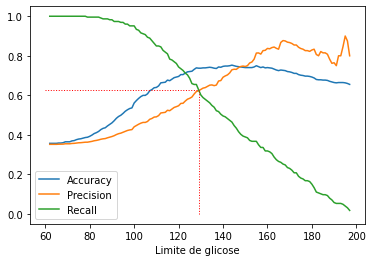

In [30]:
plt.plot(glucose_thr, accuracy_list, label='Accuracy')
plt.plot(glucose_thr, precision_list, label='Precision')
plt.plot(glucose_thr, recall_list, label='Recall')
plt.hlines(y=train_recall, xmin=60, xmax=thr_heuristic, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_heuristic, ymin=0.0, ymax=train_recall, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.legend()
plt.show()

In [31]:
# Print das métricas de treino

print("Métricas de treino:")
print(f"Acurácia: {train_accuracy}")
print(f"Precisão: {train_precision}")
print(f"Recall: {train_recall}")

Métricas de treino:
Acurácia: 0.7372
Precisão: 0.6228
Recall: 0.6283


Finalmente, vamos avaliar o modelo com os dados de teste. Essas métricas serão uma das nossas referências para avaliar a performace no final.

In [32]:
# Removendo NaN do teste

filtro_nan = X_test['Glucose'].isna()
index_nan = X_test[filtro_nan].index.tolist()

X_test_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_test_heuristic = y_train.drop(index=index_nan)

In [33]:
# Predict no dataset de teste

outcome_predict = X_test_heuristic["Glucose"].apply(test_glucose, thr=thr_heuristic)

accuracy = np.round(accuracy_score(y_test_heuristic, outcome_predict), 4)
precision = np.round(precision_score(y_test_heuristic, outcome_predict), 4)
recall = np.round(recall_score(y_test_heuristic, outcome_predict), 4)

print("Métricas de teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")

Métricas de teste:
Acurácia: 0.7362
Precisão: 0.6228
Recall: 0.6228


# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos o mínimo tratamento dos dados ou otimizações nos modelos no momento. Utilizaremos **validação cruzada** uma vez que temos poucas instâncias no dataset e reservaremos o dataset de teste para a avaliação final.

In [35]:
# Definindo uma função para avaliar os modelos com validação cruzada

def relatorio_cross_val(estimator, X_train, y_train):
    """Calcula acurácia, precisão e recall utilizando cross validation"""
    
    cv_accuracy_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_precision_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="precision")
    cv_recall_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="recall")
    
    cv_accuracy_mean_score = cv_accuracy_score.mean()
    cv_accuracy_std_score = cv_accuracy_score.std()
    
    cv_precision_mean_score = cv_precision_score.mean()
    cv_precision_std_score = cv_precision_score.std()
    
    cv_recall_mean_score = cv_recall_score.mean()
    cv_recall_std_score = cv_recall_score.std()
    
    print(f"Acurácia média: {np.round(cv_accuracy_mean_score, 4)} (std={np.round(cv_accuracy_std_score, 4)})")
    print(f"Precisão média: {np.round(cv_precision_mean_score, 4)} (std={np.round(cv_precision_std_score, 4)})")
    print(f"Recall médio: {np.round(cv_recall_mean_score, 4)} (std={np.round(cv_recall_std_score, 4)})")

In [36]:
# Voltando os NaNs para zero

X_train_fillna = X_train.fillna(0)

Começaremos com uma *decision tree* para ganhar algum insight sobre os dados:

In [37]:
# Decision tree

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train_fillna, y_train)

relatorio_cross_val(tree_clf, X_train_fillna, y_train)

Acurácia média: 0.7362 (std=0.0176)
Precisão média: 0.7241 (std=0.0287)
Recall médio: 0.4079 (std=0.1211)


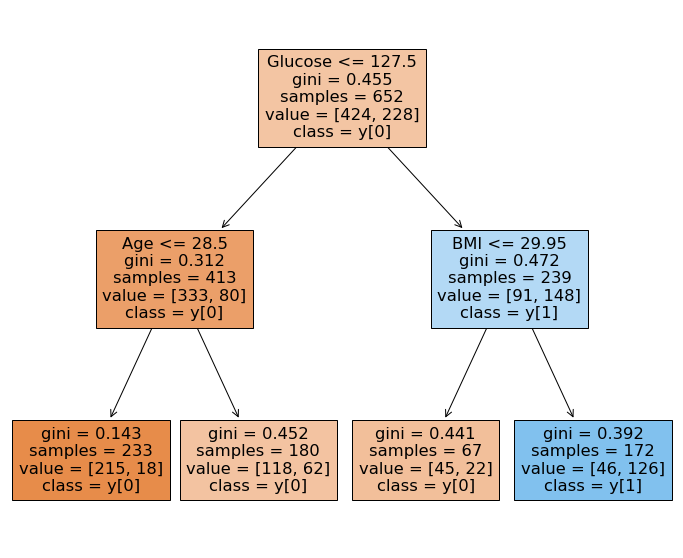

In [38]:
# Plotando árvore

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore simples, já temos uma acurácia média de 73,62%. Também confirmamos algumas expectativas: `Glucose`, `Age` e `BMI` são variáveis importantes nesse problema.

Também podemos treinar uma regressão logística, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [39]:
# Regressão logística

log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_fillna)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7622 (std=0.0245)
Precisão média: 0.7021 (std=0.0337)
Recall médio: 0.5526 (std=0.0598)


In [49]:
# Random Forest. Escolhi alguns hiperparâmetros.

forest_clf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)
forest_clf.fit(X_train_sc, y_train)
relatorio_cross_val(forest_clf, X_train_sc, y_train)

Acurácia média: 0.773 (std=0.016)
Precisão média: 0.7254 (std=0.0323)
Recall médio: 0.5658 (std=0.0322)


A partir da floresta treinada podemos extrair a importância de cada feature.

In [58]:
# Feature importance

for name, score in zip(list(X_train.columns), list(forest_clf.feature_importances_)):
    print(name, np.round(score, 2))

Pregnancies 0.08
Glucose 0.33
BloodPressure 0.06
SkinThickness 0.05
Insulin 0.07
BMI 0.16
DiabetesPedigreeFunction 0.09
Age 0.16


Novamente, vemos que `Glucose`, `BMI` e `Age` são variáveis importantes. 

Com esses modelos simples de ML temos uma acurácia melhor, mas nosso recall é significativamente menor. Mais tarde ajustaremos para otimizar o recall.

In [ ]:
# Mover a seção abaixo para a avaliação final do documento

In [60]:
# Ajuste de precisão/recall

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(log_clf, X_train_sc, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

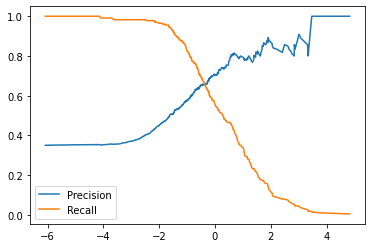

In [83]:
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.legend()
plt.show()

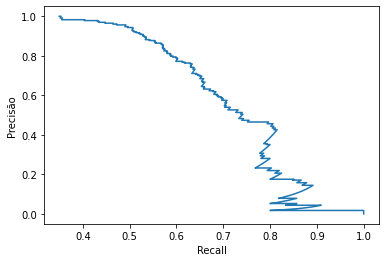

In [73]:
plt.plot(precisions, recalls)
plt.ylabel('Precisão')
plt.xlabel('Recall')
plt.show()

# Tratamento dos dados

Podemos limpar um pouco os dados antes de tentar modelos ML mais elaborados. Nessa seção, trataremos os dados faltantes e os outliers.

### Lidando com dados faltantes

Vamos comparar o SimpleImputer (testando média e mediana) e o KNNImputer.

In [66]:
# Testando SimpleImputer

sim_imp = SimpleImputer(strategy='mean')
std_scaler = StandardScaler()
log_clf = LogisticRegression()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.7638 (std=0.0124)
Precisão média: 0.7098 (std=0.0139)
Recall médio: 0.5482 (std=0.0377)


In [64]:
# Testando KNNImputer

knn_imp = KNNImputer(n_neighbors=3)
std_scaler = StandardScaler()
log_clf = LogisticRegression()

treat_steps = [('imputer', knn_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.7684 (std=0.0174)
Precisão média: 0.714 (std=0.0178)
Recall médio: 0.5614 (std=0.0484)


Vamos usar o tratamento do `KNNImputer`. Antes de prosseguir vamos analisar novamente os dados após o tratamento.

In [67]:
# Reconstruindo o dataframe

X_train_tr_full = pd.DataFrame(knn_imp.fit_transform(X_train), 
                               columns=X_train.columns, 
                               index=X_train.index).join(y_train.to_frame())

In [68]:
X_train_tr_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
227,3.0,162.0,52.0,38.000000,349.666667,37.200001,0.652,24.0,1
168,4.0,110.0,66.0,35.000000,107.333333,31.900000,0.471,29.0,0
513,2.0,91.0,62.0,18.000000,48.666667,27.299999,0.525,22.0,0
7,10.0,115.0,70.0,37.666667,145.000000,35.299999,0.134,29.0,0
196,1.0,105.0,58.0,16.666667,179.000000,24.299999,0.187,21.0,0


In [69]:
def plot_dist_box(data, column):
    "Plota histograma e boxplot de uma coluna"
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=data, x=column, hue="Outcome", ax=ax[0])
    sns.boxplot(data=data, x=column, ax=ax[1])
    plt.show()

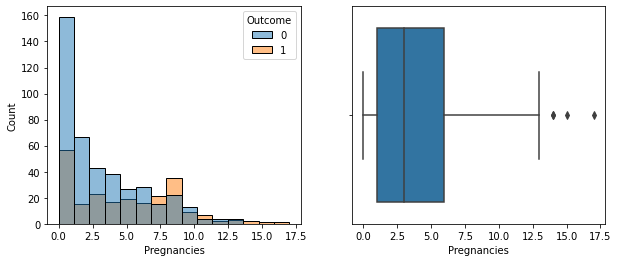

In [70]:
plot_dist_box(X_train_tr_full, "Pregnancies")

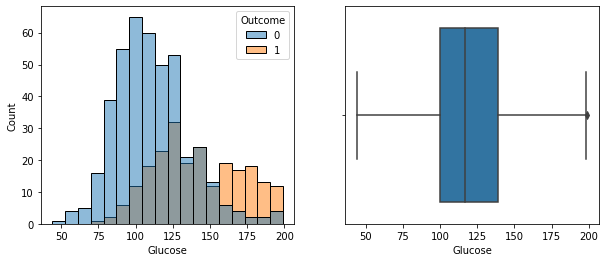

In [71]:
plot_dist_box(X_train_tr_full, "Glucose")

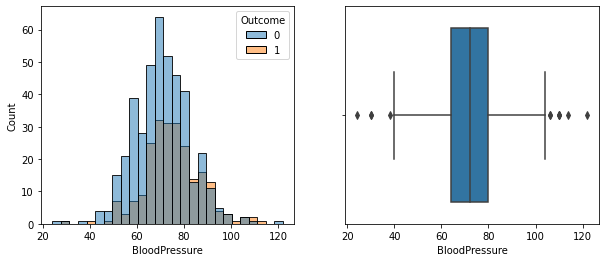

In [72]:
plot_dist_box(X_train_tr_full, "BloodPressure")

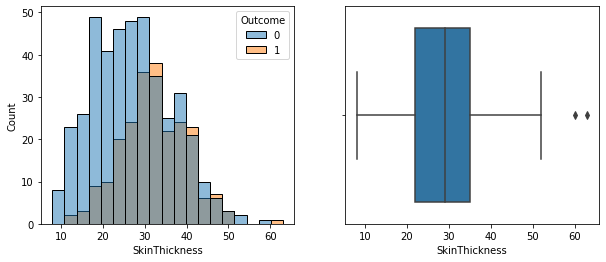

In [73]:
plot_dist_box(X_train_tr_full, "SkinThickness")

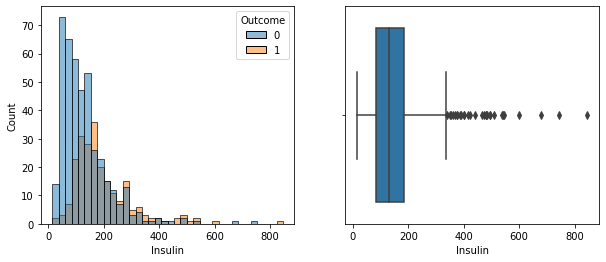

In [74]:
plot_dist_box(X_train_tr_full, "Insulin")

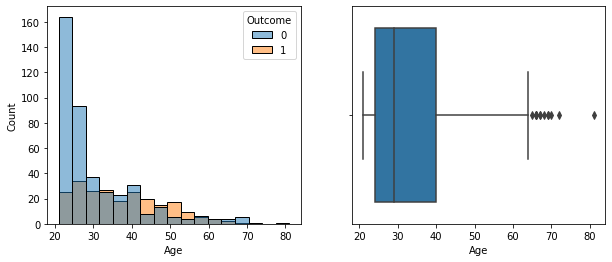

In [75]:
plot_dist_box(X_train_tr_full, "Age")

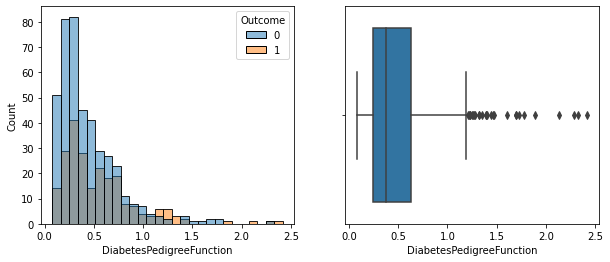

In [76]:
plot_dist_box(X_train_tr_full, "DiabetesPedigreeFunction")

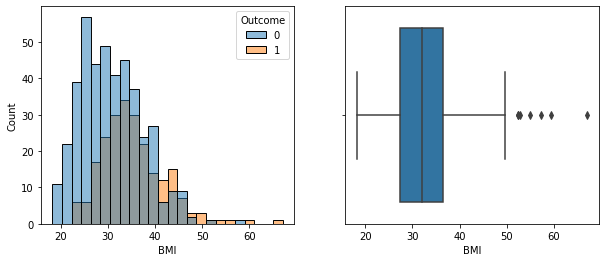

In [77]:
plot_dist_box(X_train_tr_full, "BMI")

Vamos verificar novamente a matriz de correlação.

In [78]:
corr_matrix = X_train_tr_full.corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.497759
BMI                         0.315918
Insulin                     0.301607
Age                         0.278958
SkinThickness               0.262065
Pregnancies                 0.233916
BloodPressure               0.176481
DiabetesPedigreeFunction    0.158570
Name: Outcome, dtype: float64


 Nota-se que temos uma melhor correlação com o target.

In [80]:
# Salvando o csv com os NaNs tratados

X_train_tr_full.to_csv('X_train_tr_full.csv', index=True)

### Tratando outliers

A distribuição da `DiabetesPedigreeFunction` e `Insulin` parecem muito inviesados. Aplicar um logaritmo torna ela mais normal:

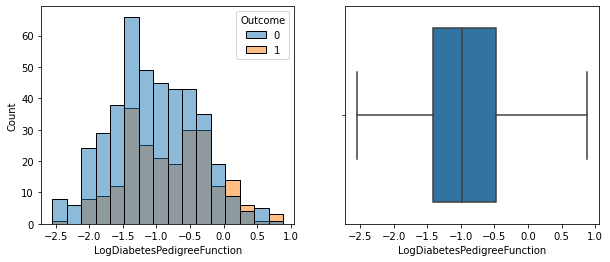

In [98]:
X_train_tr_full['LogDiabetesPedigreeFunction'] = np.log(X_train_tr_full['DiabetesPedigreeFunction'])
plot_dist_box(X_train_tr_full, "LogDiabetesPedigreeFunction")

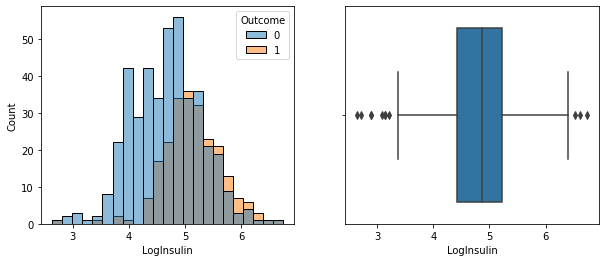

In [99]:
X_train_tr_full['LogInsulin'] = np.log(X_train_tr_full['Insulin'])
plot_dist_box(X_train_tr_full, "LogInsulin")

In [100]:
correlacao(X_train_tr_full)

Outcome                        1.000000
Glucose                        0.497759
LogInsulin                     0.353477
BMI                            0.315918
Insulin                        0.301607
Age                            0.278958
SkinThickness                  0.262065
Pregnancies                    0.233916
BloodPressure                  0.176481
LogDiabetesPedigreeFunction    0.173109
DiabetesPedigreeFunction       0.158570
Name: Outcome, dtype: float64


As distribuições parecem mais normais e as correlações melhoraram. Vamos verificar a performace. 

In [102]:
drop = ["Outcome", "Insulin", "DiabetesPedigreeFunction"]
X_train_tr = X_train_tr_full.drop(drop, axis=1)
X_train_tr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin
227,3.0,162.0,52.0,38.000000,37.200001,24.0,-0.427711,5.856980
168,4.0,110.0,66.0,35.000000,31.900000,29.0,-0.752897,4.675939
513,2.0,91.0,62.0,18.000000,27.299999,22.0,-0.644357,3.884994
7,10.0,115.0,70.0,37.666667,35.299999,29.0,-2.009915,4.976734
196,1.0,105.0,58.0,16.666667,24.299999,21.0,-1.676647,5.187386


In [103]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7607 (std=0.0177)
Precisão média: 0.6974 (std=0.0192)
Recall médio: 0.557 (std=0.0611)


Apesar das correlações melhorarem, nosso modelo teve uma performace pior. Vamos seguir sem esse tratamento.

In [104]:
X_train_full = X_train_tr_full.drop(["LogDiabetesPedigreeFunction", "LogInsulin"], axis=1)

### Binning

Vamos tentar agora agrupar dados para reduzir o ruído de alguma feature. Como discutido, fazer esse tratamento isso na `Age` talvez ajude nosso modelo. 

In [105]:
X_train_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
227,3.0,162.0,52.0,38.000000,349.666667,37.200001,0.652,24.0,1
168,4.0,110.0,66.0,35.000000,107.333333,31.900000,0.471,29.0,0
513,2.0,91.0,62.0,18.000000,48.666667,27.299999,0.525,22.0,0
7,10.0,115.0,70.0,37.666667,145.000000,35.299999,0.134,29.0,0
196,1.0,105.0,58.0,16.666667,179.000000,24.299999,0.187,21.0,0


Usaremos `KBinsDiscretizer`:

In [106]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal')
X_train_full["New_Age"] = kbins.fit_transform(X_train_full[['Age']])

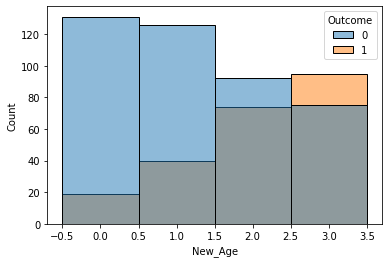

In [107]:
_ = sns.histplot(X_train_full, x="New_Age", hue="Outcome", discrete=True)

In [108]:
correlacao(X_train_full)

Outcome                     1.000000
Glucose                     0.497759
New_Age                     0.349550
BMI                         0.315918
Insulin                     0.301607
Age                         0.278958
SkinThickness               0.262065
Pregnancies                 0.233916
BloodPressure               0.176481
DiabetesPedigreeFunction    0.158570
Name: Outcome, dtype: float64


In [109]:
# Testando o binning com regressão logística

X_train_tr = X_train_full.drop(['Outcome', 'Age'], axis=1)
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7745 (std=0.014)
Precisão média: 0.7172 (std=0.0225)
Recall médio: 0.5877 (std=0.0434)


O tratamento é semelhante à uma condificação por faixa etária (criança, jovem, adulto, idoso). A correlação e as outras métricas melhoraram. Seguiremos com esse tratamento.

In [111]:
# Salvando resultados
X_train_tr.to_csv('X_train_tr_full.csv', index=True)

## Tratamento de outliers

In [132]:
X_train_full = pd.read_csv('X_train_tr_full.csv', index_col=0)
X_train_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,New_Age
227,3.0,162.0,52.0,38.000000,349.666667,37.200001,0.652,1.0
168,4.0,110.0,66.0,35.000000,107.333333,31.900000,0.471,2.0
513,2.0,91.0,62.0,18.000000,48.666667,27.299999,0.525,0.0
7,10.0,115.0,70.0,37.666667,145.000000,35.299999,0.134,2.0
196,1.0,105.0,58.0,16.666667,179.000000,24.299999,0.187,0.0


Para remover os outliers utilizaremos o método de `winsorize`.

In [133]:
from scipy.stats.mstats import winsorize
winsorize_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "Insulin"]

for col in winsorize_list:
    X_train_full["Win_"+col] = winsorize(X_train_full[col], limits=(0.01, 0.02))

In [134]:
correlacao(X_train_full.join(y_train))

Outcome                     1.000000
Win_Glucose                 0.498909
Glucose                     0.497759
New_Age                     0.349550
Win_Insulin                 0.321224
Win_BMI                     0.316090
BMI                         0.315918
Insulin                     0.301607
Win_SkinThickness           0.265912
SkinThickness               0.262065
Pregnancies                 0.233916
Win_Pregnancies             0.231643
Win_BloodPressure           0.182173
BloodPressure               0.176481
DiabetesPedigreeFunction    0.158570
Name: Outcome, dtype: float64


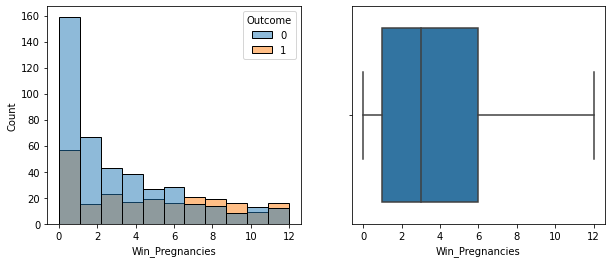

In [135]:
plot_dist_box(X_train_full.join(y_train), "Win_Pregnancies")

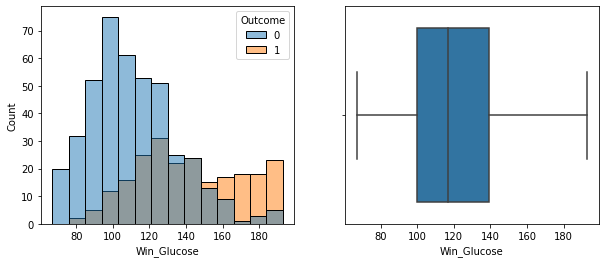

In [136]:
plot_dist_box(X_train_full.join(y_train), "Win_Glucose")

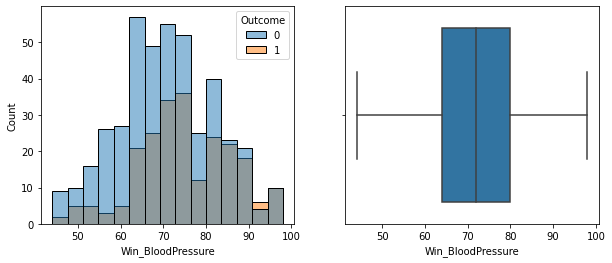

In [137]:
plot_dist_box(X_train_full.join(y_train), "Win_BloodPressure")

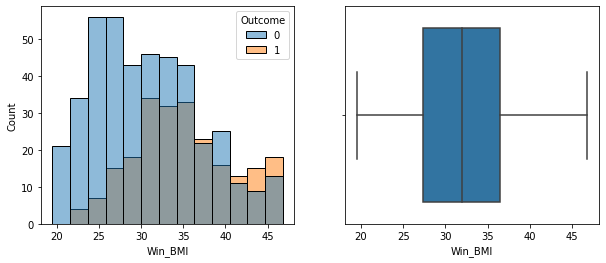

In [138]:
plot_dist_box(X_train_full.join(y_train), "Win_BMI")

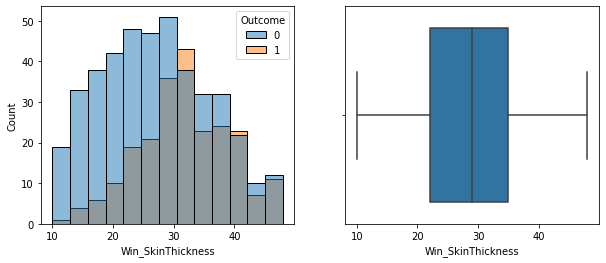

In [139]:
plot_dist_box(X_train_full.join(y_train), "Win_SkinThickness")

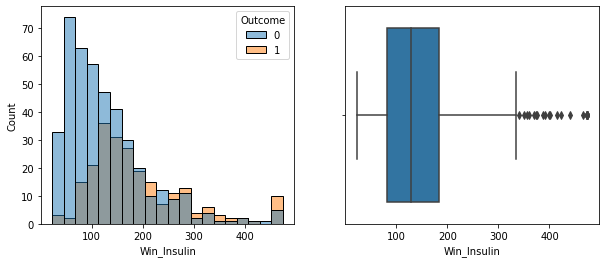

In [140]:
plot_dist_box(X_train_full.join(y_train), "Win_Insulin")

In [141]:
X_train_tr = X_train_full.drop(winsorize_list, axis=1)
X_train_tr.head()

,DiabetesPedigreeFunction,New_Age,Win_Pregnancies,Win_Glucose,Win_BloodPressure,Win_SkinThickness,Win_BMI,Win_Insulin
227,0.652,1.0,3.0,162.0,52.0,38.000000,37.200001,349.666667
168,0.471,2.0,4.0,110.0,66.0,35.000000,31.900000,107.333333
513,0.525,0.0,2.0,91.0,62.0,18.000000,27.299999,48.666667
7,0.134,2.0,10.0,115.0,70.0,37.666667,35.299999,145.000000
196,0.187,0.0,1.0,105.0,58.0,16.666667,24.299999,179.000000


In [142]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.773 (std=0.0178)
Precisão média: 0.7111 (std=0.0302)
Recall médio: 0.5921 (std=0.0387)


Perdemos um pouco de acúracia mas melhoramos o recall. Seguiremos com esse tratamento.

## Modelos finais

In [ ]:
# Função para avaliação dos resultados utilizando o dataset de teste
    
def relatorio_metricas(y_train, y_pred):
    """Calcula e imprime acurácia, precisão e recall."""
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    print(f"Acurácia: {accuracy}")
    print(f"Precisão: {precision}")
    print(f"Recall: {recall}")

In [143]:
# Reescalando

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_tr.columns, index=X_train_tr.index)
X_train_sc.head()

,DiabetesPedigreeFunction,New_Age,Win_Pregnancies,Win_Glucose,Win_BloodPressure,Win_SkinThickness,Win_BMI,Win_Insulin
227,0.532966,-0.492427,-0.243030,1.343993,-1.739592,1.027813,0.762404,2.168740
168,-0.002496,0.409434,0.061107,-0.392633,-0.522531,0.695460,-0.045472,-0.452751
513,0.157255,-1.394288,-0.547168,-1.027169,-0.870263,-1.187872,-0.746647,-1.087390
7,-0.999459,0.409434,1.885932,-0.225649,-0.174799,0.990885,0.472788,-0.045284
196,-0.842667,-1.394288,-0.851305,-0.559616,-1.217994,-1.335585,-1.203935,0.322518


### Random Forest

In [148]:
forest_clf = RandomForestClassifier(max_depth=5, max_features=7, 
                                    min_samples_split=30, n_estimators=700, 
                                    random_state=42)
forest_clf.fit(X_train_sc, y_train)
relatorio_cross_val(forest_clf, X_train_sc, y_train)

Acurácia média: 0.7623 (std=0.0169)
Precisão média: 0.6984 (std=0.0185)
Recall médio: 0.5614 (std=0.0484)


In [149]:
# # Randomized cv

# from sklearn.model_selection import RandomizedSearchCV

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# rand_search_cv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# rand_search_cv.fit(X_train_sc, y_train)
# print(rand_search_cv.best_estimator_)
# print(rand_search_cv.best_score_)

In [150]:
# Best params for forest_clf are: 
# RandomForestClassifier(max_depth=5, max_features=7, min_samples_split=30, n_estimators=700, random_state=42)

### XGBoost

In [151]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, random_state=42, n_estimators=500)
xgb_clf.fit(X_train_sc, y_train)
relatorio_cross_val(xgb_clf, X_train_sc, y_train)

Acurácia média: 0.7485 (std=0.0053)
Precisão média: 0.6511 (std=0.0053)
Recall médio: 0.6053 (std=0.0387)


In [152]:
# grid search cv para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [153]:
# Melhores params para XGB são:
# XGBClassifier(learning_rate=0.07, max_depth=6, random_state=42, n_estimators=500)

## Support-vector machine

In [154]:
from sklearn.svm import SVC

svc_clf = SVC(kernel='linear', probability=True)
svc_clf.fit(X_train_sc, y_train)
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Acurácia média: 0.7622 (std=0.0126)
Precisão média: 0.7039 (std=0.0305)
Recall médio: 0.557 (std=0.0434)


### Logistic regression

In [155]:
log_clf = LogisticRegression()
log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.773 (std=0.0178)
Precisão média: 0.7111 (std=0.0302)
Recall médio: 0.5921 (std=0.0387)


### Majority hard vote 

In [156]:
from sklearn.ensemble import VotingClassifier

estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_hard_clf = VotingClassifier(estimators, voting='hard')
voting_hard_clf.fit(X_train_sc, y_train)
relatorio_cross_val(voting_hard_clf, X_train_sc, y_train)

Acurácia média: 0.7577 (std=0.0094)
Precisão média: 0.7108 (std=0.0046)
Recall médio: 0.5175 (std=0.0447)


### Majority soft vote 

In [158]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')
voting_soft_clf.fit(X_train_sc, y_train)
relatorio_cross_val(voting_soft_clf, X_train_sc, y_train)

Acurácia média: 0.7653 (std=0.0038)
Precisão média: 0.6857 (std=0.0136)
Recall médio: 0.6096 (std=0.0377)


## Avaliação final do modelo

In [159]:
# Tratamento dos dados de teste

# Imputando
X_test_tr = imp.transform(X_test)
X_test_tr = pd.DataFrame(X_test_tr, columns=X_test.columns, index=X_test.index)

# Criando variaveis log

X_test_tr['LogDiabetesPedigreeFunction'] = np.log(X_test_tr['DiabetesPedigreeFunction'])
X_test_tr['LogInsulin'] = np.log(X_test_tr['Insulin'])
drop = ["Insulin", "DiabetesPedigreeFunction"]
X_test_tr = X_test_tr.drop(drop, axis=1)

# Binning
X_test_tr["New_Age"] = kbins.transform(X_test_tr[['Age']])
X_test_tr = X_test_tr.drop("Age", axis=1)

# Outliers

winsorize_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "LogInsulin"]

for col in winsorize_list:
    X_test_tr["Win_"+col] = winsorize(X_test_tr[col], limits=(0.01, 0.02))

X_test_tr = X_test_tr.drop(winsorize_list, axis=1)


# Scaling
X_test_sc = std_scaler.transform(X_test_tr)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_tr.columns, index=X_test_tr.index)

X_test_sc.head()

NameError: name 'imp' is not defined

In [ ]:
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    f1 = np.round(f1_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"F1 score: {f1}")
    print("-------------------------- \n")

models = [forest_clf, xgb_clf, svc_clf, log_clf, voting_hard_clf, voting_soft_clf]
models_names = ["Random Forest", "XGBoost", "SVM", "Log. Reg.", "Hard voting", "Soft voting"]

for name, model in zip(models_names, models):
    y_pred = model.predict(X_test_sc)
    print(f"*Results for {name} \n")
    metrics_report(y_test, y_pred)

In [ ]:
# Incluir modelo simplificado com PCA e plot Voronoi
# Incluir comparação com RandomForest além da LogisticRegression
# Incluir avaliação final do modelo com o dataset de teste
# Incluir 
# Avaliar matriz de confusão e impacto financeiro do modelo